Implementation and graphics generator for stepping experiments where we record *only* the count of the vanilla k set returned by each of the mechanisms.  We then plot the mean/sd as a function of one of the values so we can see how we go as we increase or decrease m or k or phi.

In [36]:
### Standard Magic and startup initializers.

import math
import csv
import numpy as np
import random
import itertools
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

from peerselect import impartial
from peerselect import profile_generator

%matplotlib inline
matplotlib.style.use('bmh')

font = {'size'   : 14}

matplotlib.rc('font', **font)
np.set_printoptions(precision=3)

#random.seed(15)

class Impartial:
    VANILLA = "Vanilla"
    EXACT = "ExactDollarPartition"
    PARTITION = "Partition"
    DPR = "DollarPartitionRaffle"
    CREDIABLE = "CredibleSubset"
    RAFFLE = "DollarRaffle"
    ALL = (VANILLA, EXACT, PARTITION, RAFFLE, CREDIABLE, DPR)

s = 5
test_n = [100]
test_k = [50]
test_m = [50]
test_l = [3]
test_p = [0.0, 0.5, 0.75, 0.8, 0.9, 0.92, 0.93, 0.95, 0.98, 0.99, 0.999999, 1.0]

# Map for all Results.
v_results = {}
gt_results = {}
for n,k,m,l,p in itertools.product(test_n, test_k, test_m, test_l, test_p):
    agents = np.arange(0, n)
    for c_sample in range(s):
        # Generate a profile and clustering
        profile = profile_generator.generate_mallows_mixture_profile(agents, agents, [1.0], [agents], [p])
        clustering = impartial.even_partition_order(sorted(agents, key=lambda j: random.random()), l)
        
        # Uncomment one:
        # Borda
        scores = np.arange(m, 0, -1)
        #Lexicographic
        #scores = [pow(n, i) for i in np.arange(m, 0, -1)]
        
        # Generate an m-regular assignment
        m_assignment = profile_generator.generate_approx_m_regular_assignment(agents, m, clustering, randomize=True)
        score_matrix = profile_generator.strict_m_score_matrix(profile, m_assignment, scores)

        #Compute Target Set.
        target_set = impartial.vanilla(score_matrix, k)
        
        # Capture the winning sets
        ws = {}
        # Let everyone else have the same size set so they are all compareable.
        vs = [i for i,j in target_set]
        ws[Impartial.VANILLA] = vs
        
        # Let CRED, PART, and RAFFLE have bigger sets...
        ws[Impartial.EXACT] = impartial.exact_dollar_partition_explicit(score_matrix, k, clustering, normalize=True)
        ws[Impartial.PARTITION] = impartial.partition_explicit(score_matrix, k, clustering, normalize=False)
        
        ws[Impartial.CREDIABLE] = impartial.credible_subset(score_matrix, k, m, normalize=False)
        ws[Impartial.DPR] = impartial.dollar_raffle_explicit(score_matrix, k, clustering, normalize=True)
        #Call Raffle and have everyone in a cluster by themselves = Dollar.
        ws[Impartial.RAFFLE] = impartial.dollar_raffle(score_matrix, k, n, randomize=True, normalize=True)
        
        for x in Impartial.ALL:
            key = (n, k, m, l, p, s, x)
            v_results[key] = v_results.get(key, []) + [len(set(vs) & set(ws[x]))]
            gt_results[key] = gt_results.get(key, []) + [len(set(np.arange(0, k)) & set(ws[x]))]
            if x == Impartial.VANILLA:
                print(ws[x])

    print("Finished: " + ",".join([str(x) for x in [n, k, m, l, p, s]]))
print("Done")

v_df = pd.DataFrame(v_results)
v_df.columns.names = ['n', 'k', 'm', 'l', 'p', 's', 'algo']

gt_df = pd.DataFrame(gt_results)
gt_df.columns.names = ['n', 'k', 'm', 'l', 'p', 's', 'algo']

[0, 3, 4, 7, 1, 8, 2, 9, 13, 5, 12, 14, 6, 10, 15, 11, 17, 19, 18, 16, 22, 20, 24, 28, 23, 21, 31, 26, 25, 32, 30, 33, 27, 29, 35, 34, 37, 36, 43, 38, 45, 39, 41, 46, 47, 40, 42, 48, 44, 49]
[0, 1, 2, 3, 4, 6, 5, 9, 7, 12, 14, 8, 10, 15, 11, 16, 17, 13, 18, 20, 19, 22, 24, 23, 21, 25, 26, 28, 27, 29, 30, 33, 32, 31, 34, 36, 38, 37, 35, 39, 40, 45, 41, 42, 43, 46, 47, 44, 49, 51]
[0, 2, 3, 5, 4, 1, 8, 9, 6, 10, 11, 7, 13, 12, 14, 15, 17, 16, 18, 19, 20, 21, 22, 24, 23, 25, 26, 27, 28, 29, 34, 31, 30, 32, 36, 35, 33, 37, 42, 38, 39, 40, 41, 44, 43, 46, 47, 45, 50, 48]
[1, 0, 2, 4, 3, 6, 7, 5, 14, 10, 8, 11, 9, 17, 12, 13, 22, 20, 15, 16, 18, 28, 19, 21, 27, 23, 32, 33, 24, 26, 25, 29, 31, 38, 30, 40, 42, 36, 34, 43, 35, 37, 44, 45, 41, 46, 39, 47, 52, 54]
[0, 3, 2, 5, 6, 1, 4, 9, 8, 7, 12, 16, 10, 11, 15, 19, 17, 20, 13, 18, 14, 25, 22, 26, 21, 23, 24, 28, 29, 27, 31, 32, 34, 30, 36, 33, 35, 38, 37, 40, 39, 41, 42, 43, 44, 45, 47, 46, 52, 48]
Finished: 100,50,50,3,0.0,5
[0, 1, 3, 5, 8, 2

In [28]:
#
# Takes a slice of the array and generates the graphs etc.
#
def make_output(df, test):
    means = df.loc[:, test].mean().unstack()
    errors = df.loc[:, test].std().unstack()
    mins = df.loc[:, test].min().unstack()

    means = means[['Vanilla','ExactDollarPartition', 'Partition', 'DollarPartitionRaffle', 'DollarRaffle', 'CredibleSubset']]
    errors = errors[['Vanilla','ExactDollarPartition', 'Partition', 'DollarPartitionRaffle', 'DollarRaffle', 'CredibleSubset']]
    print("MEAN:\n\t" + str(means[['Vanilla','ExactDollarPartition', 'Partition']]))
    print("STD:\n\t" + str(errors[['Vanilla','ExactDollarPartition', 'Partition']]))
    print("MIN:\n\t" + str(mins[['Vanilla','ExactDollarPartition', 'Partition']]))

    for index, row in means.iterrows():
        means.ix[index] = row / float(index[1])
    for index, row in errors.iterrows():
        errors.ix[index] = row / float(index[1])

    means.plot(kind='bar', legend=False, yerr=errors.values.T, figsize=(20, 10), ylim=(0, 1.05))
    plt.title("Strict Preferences, Borda Scoring")
    plt.legend(bbox_to_anchor = (0,0.01,1,1), bbox_transform=plt.gcf().transFigure, loc='upper center', ncol=6, borderaxespad=0.)
    plt.show()
    




		Approximate Vanilla Ordering
MEAN:
	algo                    Vanilla  ExactDollarPartition  Partition
n   k  m  l p        s                                          
100 50 50 3 0.000000 5       50                  48.6       47.6
            0.500000 5       50                  48.6       47.6
            0.750000 5       50                  48.8       47.0
            0.800000 5       50                  48.6       47.6
            0.900000 5       50                  48.4       47.8
            0.920000 5       50                  49.0       48.4
            0.930000 5       50                  48.4       47.2
            0.950000 5       50                  48.8       48.6
            0.980000 5       50                  46.6       46.6
            0.990000 5       50                  46.2       45.4
            0.999999 5       50                  45.0       44.6
            1.000000 5       50                  44.4       44.0
STD:
	algo                    Vanilla  ExactDollarPa

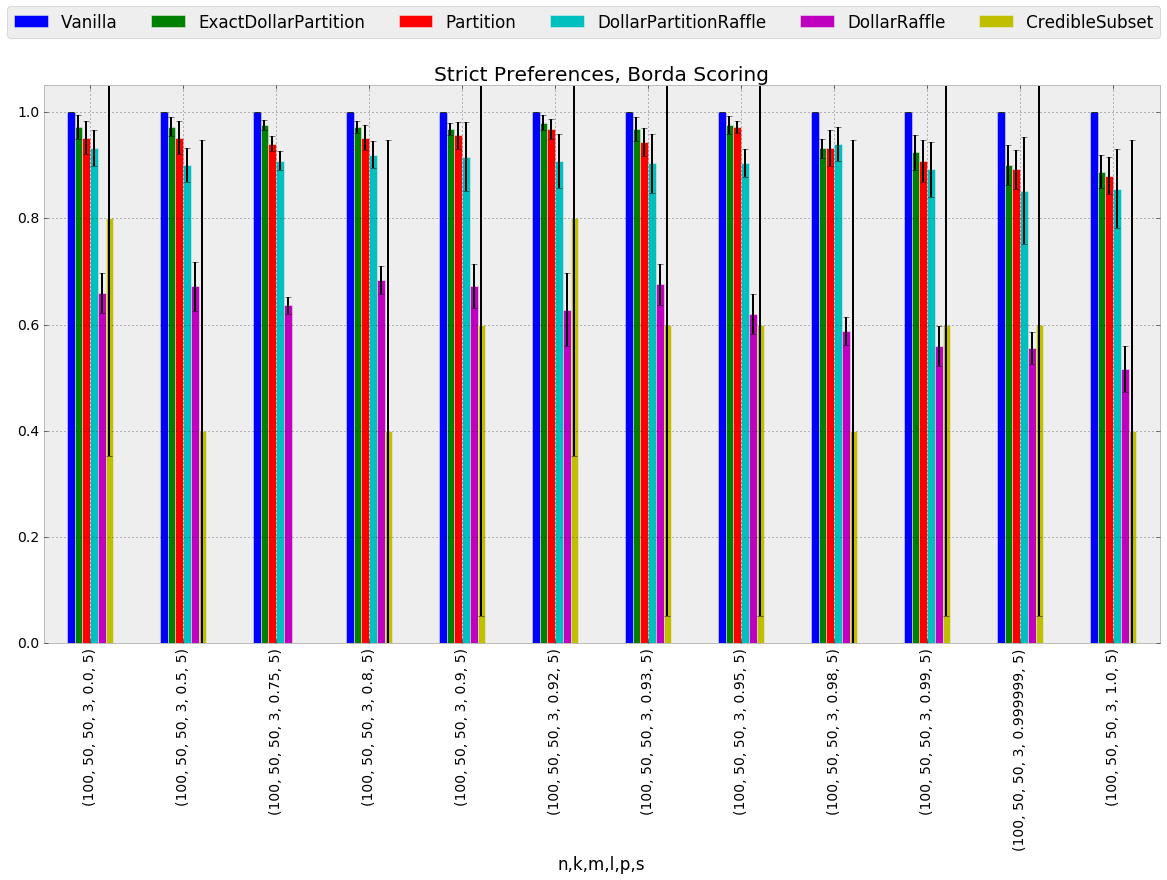

		Approximate GT Ordering
MEAN:
	algo                    Vanilla  ExactDollarPartition  Partition
n   k  m  l p        s                                          
100 50 50 3 0.000000 5     49.0                  48.8       47.6
            0.500000 5     49.0                  47.8       46.8
            0.750000 5     49.0                  47.8       46.4
            0.800000 5     49.2                  48.2       47.2
            0.900000 5     49.0                  47.8       47.2
            0.920000 5     48.6                  48.0       48.2
            0.930000 5     48.4                  47.6       46.4
            0.950000 5     47.6                  47.4       47.4
            0.980000 5     46.2                  44.4       44.0
            0.990000 5     40.2                  39.6       39.8
            0.999999 5     23.6                  23.2       23.4
            1.000000 5     25.8                  26.4       26.2
STD:
	algo                     Vanilla  ExactDollarPartit

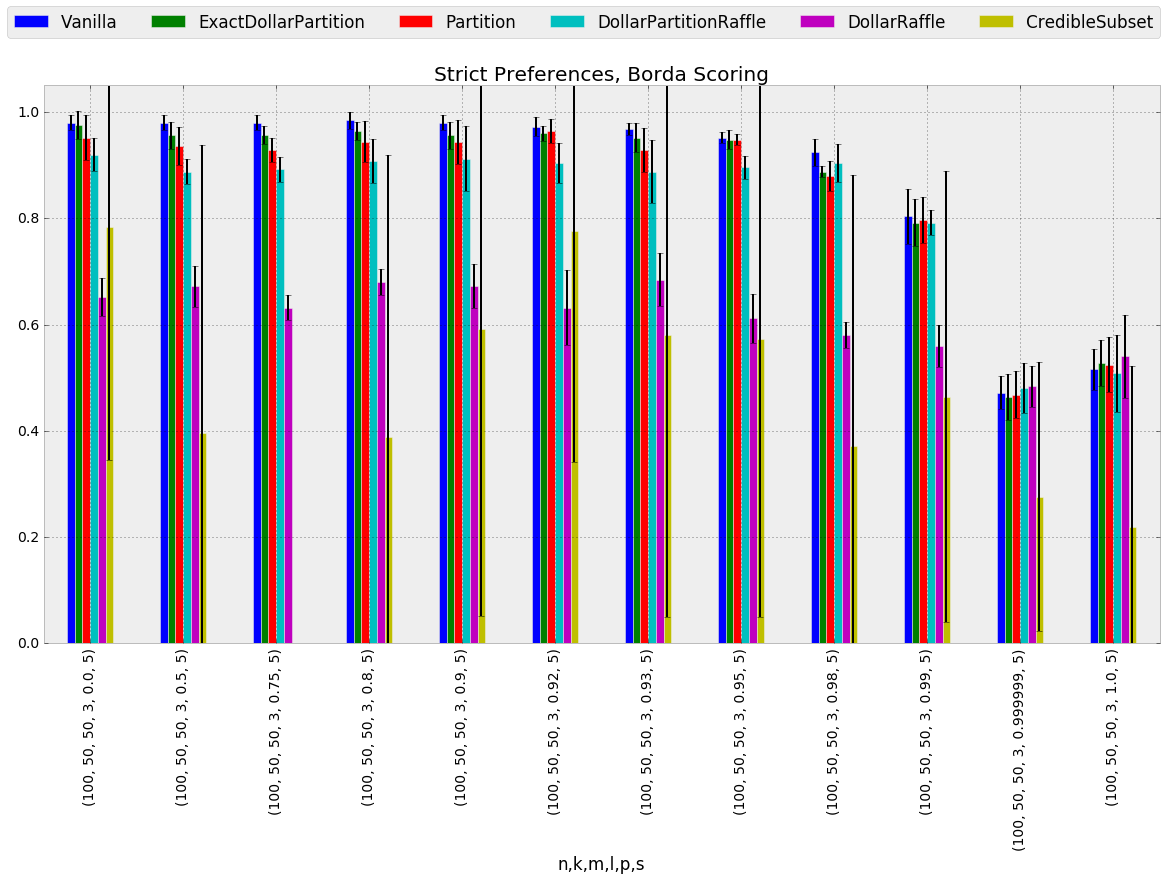

In [37]:
#  ['n', 'k', 'm', 'l', 'p', 's', 'algo']
print("\t\tApproximate Vanilla Ordering")
make_output(v_df, (n, k, m, l, slice(None), s))
print("\t\tApproximate GT Ordering")
make_output(gt_df, (n, k, m, l, slice(None), s))